In [1]:
!pip install gurobipy
!pip install "cvxpy[GUROBI]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 25.1 MB/s eta 0:00:00


In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
from tqdm import tqdm
import cvxpy as cp
import seaborn as sns
import gurobipy
# import tikzplotlib
import webcolors

### Supporting Functions

In [3]:
def generate_redgreen(m, gamma, seed):
  """Generates m bits of iid Bernoulli(gamma).

  Args:
    m: Number of elements.
    gamma: The probability of success (1).
    seed: Random seed.

  Returns:
     A NumPy array of m bits.
  """
  np.random.seed(seed)
  return np.random.binomial(1, gamma, size=m)

def generate_balanced_rg(m, gamma, seed):
  np.random.seed(seed)
  ones = int(m*gamma)
  zeros = m - ones
  elements = np.array([1] * ones + [0] * zeros)
  np.random.shuffle(elements)
  return elements

def generate_distribution(m, L2_norm, seed):
    """Generates Q: synthetic LLM probability distribution over m tokens for a given l2-norm.

    Args:
      m: Number of elements in the probability distribution.
      L2_norm: Desired L2 norm of the distribution.
      seed: Random seed.

    Returns:
      probability distribution: NumPy array of m bits.
    """
    # Objective function to minimize
    def objective(p):
        return 0  # We don't need to minimize any particular function, so we return 0.

    # Constraints: sum to 1 and have an L2 norm of L
    constraints = [
        {'type': 'eq', 'fun': lambda p: np.sum(p) - 1},  # Sum of elements is 1
        {'type': 'eq', 'fun': lambda p: np.linalg.norm(p) - L2_norm}  # L2 norm is L
    ]

    # Bounds: all elements should be non-negative
    bounds = [(0, None) for _ in range(m)]

    # Initial guess
    np.random.seed(seed)
    initial_guess = np.random.rand(m)

    # Perform the optimization
    result = minimize(objective, initial_guess, constraints=constraints, bounds=bounds)

    # Check if optimization was successful
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed to find a valid distribution.")

def tilt_q_RG(distribution, delta, rg_list):
    """Tilt the distribution by a multiplicative factor of delta
        according to a red/green list.

    Args:
      distribution: original distribution.
      delta: multiplicative factor.
      rg_list: red/green list

    Returns:
      tilted distribution: NumPy array of m bits.
    """
    # print(rg_list)
    # print("Original distribution:", distribution)
    # Convert to numpy arrays for easy manipulation
    distribution = np.array(distribution)
    rg_list = np.array(rg_list)

    # Multiply by (1+delta) to elements where Bernoulli_list is 1
    distribution += distribution * delta * rg_list

    # Normalize to ensure the probabilities sum to 1
    distribution /= np.sum(distribution)

    # print("Tilted distribution:", distribution)
    # print("Sum of elements:", np.sum(distribution))
    return distribution


def total_variation_distance(q, q_tilt):
    """Compute the total variation distance between q and q_tilt."""
    return 0.5 * np.sum(np.abs(q - q_tilt))


In [4]:
class TVopt:
  def __init__(self, m, d):
    self.m = m  # Number of points
    self.d = d  # Dimension

    # Variables
    self.v = [cp.Variable(self.d) for _ in range(self.m)]
    self.z = [cp.Variable(self.d, nonneg=True) for _ in range(self.m)]
    self.b = [cp.Variable(self.d, boolean=True) for _ in range(self.m)]

    # Parameters
    self.p = cp.Parameter(self.d, nonneg=True)  # Parameter for p
    self.w = cp.Parameter(self.m, nonneg=True)  # Parameter for weights
    self.epsilon = cp.Parameter(nonneg=True)  # Parameter for epsilon

    # Objective: Maximize sum(w_i * z_i)
    self.objective = cp.Maximize(sum(self.w[i] * cp.sum(self.z[i]) for i in range(self.m)))

    # Constraints
    self.constraints = []
    M = 3  # Large constant

    # Sum of v_i,j equals zero
    for i in range(self.m):
      self.constraints.append(cp.sum(self.v[i]) == 0)

    # Bounds on v_i
    for i in range(self.m):
      self.constraints.append(self.v[i] >= -self.p)
      self.constraints.append(self.v[i] <= 1 - self.p)

    # Relationship between v_i and z_i
    for i in range(self.m):
      self.constraints.append(self.v[i] <= self.z[i])
      self.constraints.append(-self.v[i] <= self.z[i])
      self.constraints.append(self.v[i] + M * self.b[i] >= self.z[i])
      self.constraints.append(-self.v[i] + M * (1 - self.b[i]) >= self.z[i])

    # Penalty on weighted sum of v_i
    weighted_sum_v = sum(self.w[i] * self.v[i] for i in range(self.m))
    self.constraints.append(0.5 * cp.norm1(weighted_sum_v) <= self.epsilon)

    # Set up the problem
    self.problem = cp.Problem(self.objective, self.constraints)

    # Solution information
    self.optimal_value = None
    self.status = None
    self.solved = False  # Flag to indicate if the problem has been previously solved
    self.q = None  # Variables for q values
    self.q_mean = None  # Variable for q_mean value
    self.perception = None # Variable for perception value
    self.detection = None # Variable for detection value

  # def solve(self, w, p, epsilon, verbose=False,solver='GUROBI'):
  def solve(self, w, p, epsilon, verbose=False,solver='GUROBI'):
    # Normalize inputs
    p = p / sum(p)
    w = w / sum(w)

    # adjust TV bound based on epsilon:
    tv_bound = 2*epsilon-1

    # Set parameter values
    self.p.value = p
    self.w.value = w
    self.epsilon.value = tv_bound

    # Set up and solve the problem with warm start
    if not self.solved:
      for var in self.v + self.z + self.b:
        var.value = np.zeros(self.d)  # Initialize variables to zeros for the first solve (warm start).

    self.problem.solve(solver=solver, warm_start=True, verbose=verbose)

    # Store results
    self.optimal_value = self.problem.value
    self.status = self.problem.status
    self.solved = True

    # Compute q and q_mean
    self.q = np.array([self.v[i].value + p for i in range(self.m)])
    self.q_mean = np.average(self.q, axis=0, weights=w)

    # TV Perception
    self.perception = (1 + .5*np.linalg.norm(p - self.q_mean, ord=1)) / 2

    # TV Detection
    self.detection = (1 + .5*np.average(np.linalg.norm(p-self.q, ord=1, axis=1), axis=0, weights=w)) / 2


In [5]:
# correlated channel method (assume binary side_info and binary rg_list)
def tilt_q_CCW(distribution, side_info, rg_list):
    size_sideinfo = 2
    p_side_info = 1/size_sideinfo # assume uniform dist over |S|
    # sum up distribution where rg_list is 0 and 1
    p_0 = sum(distribution * (1-rg_list)) # sum of probabilities for tokens in list 0
    p_1 = sum(distribution * rg_list) # sum of probabilities for tokens in list 1
    # four cases
    if p_1 <= 0.5:
      if side_info == 0:
        # multiple by 1/p_0 to elements where rg_list is 0
        distribution = distribution * (1/p_0) * (1- rg_list)
        # effectively tokens in rg_list 1 is set to 0 probability
      else:
        # multiple by 2-1/p0 to elements where rg_list is 0
        distribution_segment0 = distribution * (2-1/p_0) * (1- rg_list)
        # multiple by 2 to elements where rg_list is 1
        distribution_segment1 = distribution * 2 * rg_list
        distribution = distribution_segment1 + distribution_segment0
    else:
      if side_info == 0:
        # multiple by 2 to elements where rg_list is 0
        distribution_segment0 = distribution * 2 * (1-rg_list)
        # multiple by 2-1/p0 to elements where rg_list is 1
        distribution_segment1 = distribution * (2-1/p_1) * (rg_list)
        distribution = distribution_segment1 + distribution_segment0
      else:
        # multiple by 1/p_1 to elements where rg_list is 1
        distribution = distribution * (1/p_1) * rg_list
        # effectively tokens in rg_list 0 is set to 0 probability
    return distribution

In [6]:
# Function to sample from a watermarked or non-watermark dist with equal probability
# and compute correct detection of green tokens
def sampling(distribution, tilted_distribution, rg_list, seed):
    #np.random.seed(seed)
    # Randomly sample a bit (0 or 1) w probability 1/2
    bit = np.random.choice([0, 1])
    #print('chosen distribution:', bit)
    # Select distribution to sample from based on bit
    chosen_distribution = distribution if bit == 0 else tilted_distribution

    # Sample 1 element from the chosen distribution
    sampled_element = np.random.choice(len(chosen_distribution), size=1, p=chosen_distribution)

    # Determine whether it is from green list (1 in rg_list)
    green_hit = rg_list[sampled_element].item()

    return green_hit, bit

def one_shot_detection_experiment(distribution, tilted_distribution, rg_list, side_info = None, method = 'rg'):
    results = []
    FPR_results = []
    FNR_results = []
    watermarked_ct = 0
    notwatermarked_ct = 0
    for _ in range(100):
        green_hit, bit = sampling(distribution, tilted_distribution, rg_list, _)
        # compute correct detection or not
        if method=='rg':
          detection_correctness = int(bit == green_hit)
          FNR = int(bit == 1 and green_hit == 0)
          FPR = int(bit == 0 and green_hit == 1)
        elif method == 'ccw':
          decision = int(green_hit==side_info)
          detection_correctness = int(bit == decision)
          FNR = int(bit == 1 and decision == 0)
          FPR = int(bit == 0 and decision == 1)
        else:
          raise ValueError("Invalid method. Use 'rg' or 'ccw'.")
        FNR_results.append(FNR)
        FPR_results.append(FPR)
        watermarked_ct += int(bit == 1)
        notwatermarked_ct += int(bit == 0)
        #print(detection_correctness)
        results.append(detection_correctness)
    detection_accuracy = sum(results) / len(results)
    ave_FPR = sum(FPR_results) / notwatermarked_ct
    ave_FNR = sum(FNR_results) / watermarked_ct
    assert((watermarked_ct+notwatermarked_ct)==100)
    #print((ave_FPR*notwatermarked_ct + ave_FNR* watermarked_ct)/(notwatermarked_ct+watermarked_ct))
    #print(1-detection_accuracy)
    # print('FPR', sum(FPR_results))
    # print('FNR', sum(FNR_results))
    # print('watermarked_ct', watermarked_ct)
    # print('notwatermarked_ct', notwatermarked_ct)
    return detection_accuracy, ave_FPR, ave_FNR, bit

### Correlated Channel and R/G One-Shot

In [7]:
def experiment_z_channel(orig_dist):
  accuracy_list = []
  fpr_list = []
  fnr_list = []
  watermarked_ct = 0
  n_trials = 100
  for itr in range(n_trials):
    side_info = np.random.choice([0, 1])

    # generate red/green list
    m = 10  # Number of elements
    gamma = 1/2 # Probability of success
    seed = itr # Random seed
    rglist = generate_redgreen(m, gamma, seed)

    tilt_q_ccw = tilt_q_CCW(orig_dist, side_info, rglist)

    detection_accuracy, ave_FPR, ave_FNR, bit = one_shot_detection_experiment(orig_dist, tilt_q_ccw, rglist, side_info, method = 'ccw')
    accuracy_list.append(detection_accuracy)
    fpr_list.append(ave_FPR)
    fnr_list.append(ave_FNR)
    if bit == 1:
      watermarked_ct += 1

  # Calculate mean and standard error for each metric
  means = [np.mean(accuracy_list), np.mean(fpr_list), np.mean(fnr_list)]
  # stds = [np.std(accuracy_list, ddof=1)/np.sqrt(n_trials),  # Standard Error for Accuracy
  #         np.std(fpr_list, ddof=1)/np.sqrt(n_trials),       # Standard Error for FPR
  #         np.std(fnr_list, ddof=1)/np.sqrt(n_trials)]       # Standard Error for FNR
  stds = [np.std(accuracy_list, ddof=1),  # Standard Error for Accuracy
          np.std(fpr_list, ddof=1),       # Standard Error for FPR
          np.std(fnr_list, ddof=1)]       # Standard Error for FNR
  print('watermark ratio:', watermarked_ct/100)
  return means, stds

In [8]:
def experiment_z_channel_balanced(orig_dist):
  accuracy_list = []
  fpr_list = []
  fnr_list = []
  watermarked_ct = 0
  n_trials = 100
  for itr in range(n_trials):
    side_info = np.random.choice([0, 1])

    # generate red/green list
    m = 10  # Number of elements
    gamma = 1/2 # Probability of success
    seed = itr # Random seed
    rglist = generate_balanced_rg(m, gamma, seed)
    # ones = int(m*gamma)
    # zeros = m - ones
    # rglist = np.array([1] * ones + [0] * zeros)

    tilt_q_ccw = tilt_q_CCW(orig_dist, side_info, rglist)

    detection_accuracy, ave_FPR, ave_FNR, bit = one_shot_detection_experiment(orig_dist, tilt_q_ccw, rglist, side_info, method = 'ccw')
    accuracy_list.append(detection_accuracy)
    fpr_list.append(ave_FPR)
    fnr_list.append(ave_FNR)
    if bit == 1:
      watermarked_ct += 1

  # Calculate mean and standard error for each metric
  means = [np.mean(accuracy_list), np.mean(fpr_list), np.mean(fnr_list)]
  # stds = [np.std(accuracy_list, ddof=1)/np.sqrt(n_trials),  # Standard Error for Accuracy
  #         np.std(fpr_list, ddof=1)/np.sqrt(n_trials),       # Standard Error for FPR
  #         np.std(fnr_list, ddof=1)/np.sqrt(n_trials)]       # Standard Error for FNR
  stds = [np.std(accuracy_list, ddof=1),  # Standard Error for Accuracy
          np.std(fpr_list, ddof=1),       # Standard Error for FPR
          np.std(fnr_list, ddof=1)]       # Standard Error for FNR
  print('watermark ratio:', watermarked_ct/100)
  return means, stds

In [9]:
def experiment_rg(orig_dist, delta):
  accuracy_list = []
  fpr_list = []
  fnr_list = []
  watermarked_ct = 0
  n_trials = 100
  for itr in range(n_trials):
    side_info = np.random.choice([0, 1])

    # generate red/green list
    m = 10  # Number of elements
    gamma = 1/2 # Probability of success
    seed = itr # Random seed
    rglist = generate_redgreen(m, gamma, seed)

    tilt_q_rg = tilt_q_RG(orig_dist, delta, rglist)

    detection_accuracy, ave_FPR, ave_FNR, bit = one_shot_detection_experiment(orig_dist, tilt_q_rg, rglist, side_info=None, method = 'rg')
    accuracy_list.append(detection_accuracy)
    fpr_list.append(ave_FPR)
    fnr_list.append(ave_FNR)
    if bit == 1:
      watermarked_ct += 1

  # Calculate mean and standard error for each metric
  means = [np.mean(accuracy_list), np.mean(fpr_list), np.mean(fnr_list)]
  # stds = [np.std(accuracy_list, ddof=1)/np.sqrt(n_trials) ,  # Standard Error for Accuracy
  #         np.std(fpr_list, ddof=1) /np.sqrt(n_trials),       # Standard Error for FPR
  #         np.std(fnr_list, ddof=1)/np.sqrt(n_trials)]       # Standard Error for FNR
  stds = [np.std(accuracy_list, ddof=1) ,  # Standard Error for Accuracy
          np.std(fpr_list, ddof=1) ,       # Standard Error for FPR
          np.std(fnr_list, ddof=1)]       # Standard Error for FNR
  return means[0], stds[0]
  print('watermark ratio:', watermarked_ct/100)
  return means, sems



In [10]:
# RG experiment with fixed Q, varying delta parameter in Q'
def experiment_RG_detection_delta(orig_dist, delta_list):
  rg_detection_mean = []
  rg_detection_sem = []

  for delta in delta_list:
    mean, sem = experiment_rg(orig_dist, delta)
    rg_detection_mean.append(mean)
    rg_detection_sem.append(sem)
  return rg_detection_mean, rg_detection_sem

def expected_tilted_distribution(q, delta, num_tilts):
    """Compute the expected tilted distribution by averaging several tilts."""
    tilted_distributions = []
    for seed in range(num_tilts):
        # Generate a red/green list
        m = 10  # Number of elements
        gamma = 1/2 # Probability of success
        rglist = generate_redgreen(m, gamma, seed)
        tilted_q = tilt_q_RG(q, delta, rglist)
        tilted_distributions.append(tilted_q)
    expected_q_tilted = np.mean(tilted_distributions, axis=0)
    #print(expected_q_tilted)
    return expected_q_tilted

def exp_fixed_q_vary_delta_perception(q, delta_list):
  '''
  q: original distribution.
  tunable parameters:
    delta_list = np.arange(0, 100, 0.5),
    number of red/green lists sampled for each delta = 80
  '''
  # generate delta parameter for perturbed distribution Q'
  perception_list = []
  for delta in delta_list:
    num_tilts = 80
    expected_q_tilted = expected_tilted_distribution(q, delta, num_tilts)
    #print(expected_q_tilted)
    TV_distance = total_variation_distance(q, expected_q_tilted)
    #print(0.5*(1+TV_distance))
    perception_list.append(0.5*(1+TV_distance))
  return perception_list


In [34]:
# RG delta (parameter for distortion)
delta_list = [round(x, 2) for x in np.arange(0, 100, 1)]

# uniform distribution
orig_dist = np.ones(10)
# orig_dist = np.array([1,1]+[0]*8)
orig_dist = orig_dist/sum(orig_dist)
rg_detection_mean, rg_detection_sem = experiment_RG_detection_delta(orig_dist, delta_list)
rg_detection_mean = np.array(rg_detection_mean)
rg_detection_sem = np.array(rg_detection_sem)
perception_list = exp_fixed_q_vary_delta_perception(orig_dist, delta_list)

In [35]:
# correlated channel result
means_CCW, sems_CCW = experiment_z_channel(orig_dist)
detection_CCW = means_CCW[0]
sem_CCW = sems_CCW[0]

watermark ratio: 0.46


In [36]:
# correlated channel balanced
means_CCW_balanced, sems_CCW_balanced = experiment_z_channel_balanced(orig_dist)
detection_CCW_balanced = means_CCW_balanced[0]
sem_CCW_balanced = sems_CCW_balanced[0]

watermark ratio: 0.53


In [37]:
## Run the TVopt class for different values of epsilon and plot the results
d = 10 # dimension
# distribution Q_x
# p = np.ones(d)
# p = p/sum(p)
p=orig_dist
n_points = 100 # Number of plot points
m_range = [2,3]

tvopt_detection_list = []
tvopt_perception_list = []

# Arrays to store perception and detection values
perception_values = np.zeros(n_points)
detection_values = np.zeros(n_points)
epsilon_values = np.linspace(.5, 1, n_points) # upper bound on perception

for m in m_range:
    tvopt = TVopt(m=m, d=d)
    w = np.ones(m)
    w = w/sum(w)

    # Solve the problem for different epsilon values
    for idx in tqdm(range(n_points)):
      epsilon = epsilon_values[idx]
      tvopt.solve(w, p, epsilon)
      perception_values[idx] = tvopt.perception
      detection_values[idx] = tvopt.detection

    tvopt_detection_list.append(detection_values.copy())
    tvopt_perception_list.append(perception_values.copy())


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


<ipython-input-39-c3404a91f625>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(0.5, detection_CCW_balanced, xerr=0, yerr=sem_CCW_balanced, fmt='ro',markersize=5, color = 'purple', label=r"CC Balanced (Ours), $|S|$=2", alpha = 0.3)


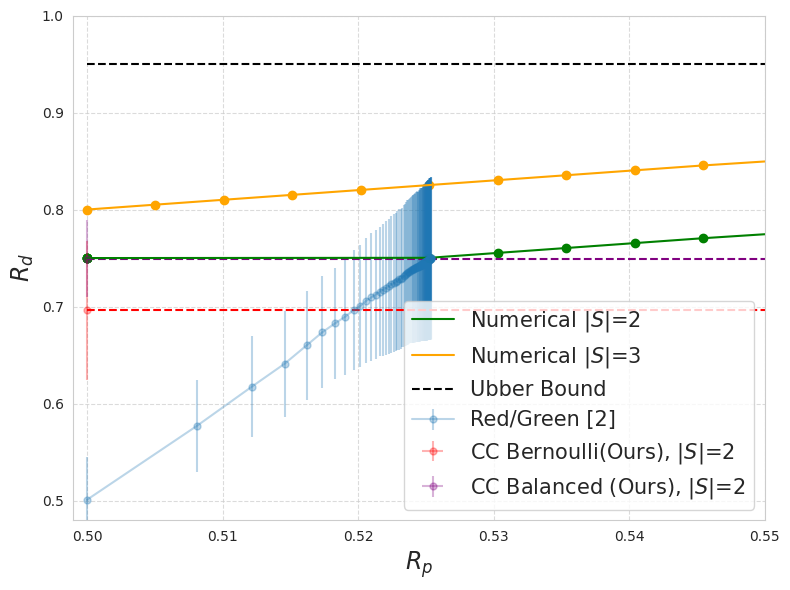

In [39]:
# Plotting RG
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
# plt.plot(perception_list, rg_detection_mean, linewidth=2,  label = 'Red/Green [2]')
# plt.fill_between(perception_list, rg_detection_mean - rg_detection_sem, rg_detection_mean + rg_detection_sem, alpha=0.3)
# plt.scatter(perception_list,rg_detection_mean, color = '#1f77b4')
plt.errorbar(perception_list, rg_detection_mean, yerr=rg_detection_sem,  markersize=5, fmt='o-', color = '#1f77b4', label = 'Red/Green [2]', alpha = 0.3 )
plt.xlabel(r'$R_p$', fontsize=17)
plt.ylabel(r'$R_d$', fontsize=17)

# Plotting Correlated Channel
# plt.plot([0.5], [detection_CCW], 'ro', label = 'CC (Ours), |S|=2')
# plt.fill_between([0.5], [detection_CCW-sem_CCW], [detection_CCW+sem_CCW], alpha=0.3)
plt.errorbar(0.5, detection_CCW, xerr=0, yerr=sem_CCW, fmt='ro',markersize=5, label=r"CC Bernoulli(Ours), $|S|$=2", alpha = 0.3)
x = np.linspace(.5,1,100)
y = (detection_CCW)*np.ones(100)
plt.plot(x,y,'--',color='red')

plt.errorbar(0.5, detection_CCW_balanced, xerr=0, yerr=sem_CCW_balanced, fmt='ro',markersize=5, color = 'purple', label=r"CC Balanced (Ours), $|S|$=2", alpha = 0.3)
x = np.linspace(.5,1,100)
y = (detection_CCW_balanced)*np.ones(100)
plt.plot(x,y,'--',color='purple')

# Plotting TV optimal
plt.plot(tvopt_perception_list[0], tvopt_detection_list[0],label=r'Numerical $|S|$=2', color = 'green')
plt.scatter(tvopt_perception_list[0], tvopt_detection_list[0],color = 'green')

plt.plot(tvopt_perception_list[1], tvopt_detection_list[1],label=r'Numerical $|S|$=3', color = 'orange')
plt.scatter(tvopt_perception_list[1], tvopt_detection_list[1], color = 'orange')

# Upper bound
x = np.linspace(.5,1,100)
y = (1-.5/d)*np.ones(100)
plt.plot(x,y,'--',label='Ubber Bound',color='black')
plt.xlim([0.499,0.55])
plt.ylim([0.48,1])

title = 'Detection-Perception Trade-off for Uniform Distribution with |X|=10'
# plt.title(title, fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('RG_CCW_Bounds.pdf', format='pdf', bbox_inches='tight')  # Save as PNG with high resolution
# tikzplotlib.save("RG_CCW_Bounds.tex")
plt.show()

100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


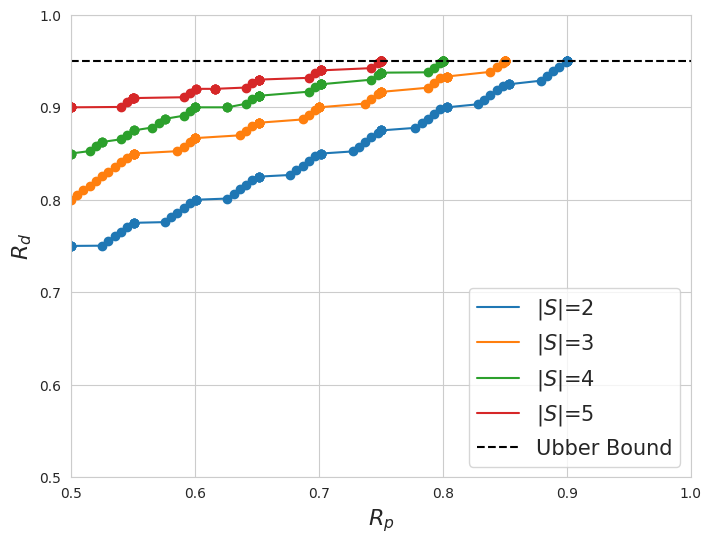

In [32]:
## Run the TVopt class for different values of epsilon and plot the results

sns.set_style("whitegrid")

d = 10 # dimension

# distribution Q_x
p = np.ones(d)
p = p/sum(p)


m_max = 5 # maximum cardinality of S


# Number of plot points
n_points = 100

# Arrays to store perception and detection values

perception_values = np.zeros(n_points)
detection_values = np.zeros(n_points)

epsilon_values = np.linspace(.5, 1, n_points) # upper bound on perception

# Plot the results
plt.figure(figsize=(8, 6))
plt.xlim([.5,1])
plt.ylim([.5,1])

for m in range(2,m_max+1):
    tvopt = TVopt(m=m, d=d)
    w = np.ones(m)
    w = w/sum(w)

    # Solve the problem for different epsilon values
    for idx in tqdm(range(n_points)):
      epsilon = epsilon_values[idx]
      tvopt.solve(w, p, epsilon)
      perception_values[idx] = tvopt.perception
      detection_values[idx] = tvopt.detection

    # Plot perception
    plt.plot(perception_values, detection_values,label=r'$|S|$='+str(m))
    plt.scatter(perception_values, detection_values)


plt.xlabel(r'$R_p$',fontsize=16)
plt.ylabel(r'$R_d$',fontsize=16)
# plt.title('Perception-Detection Optimal Trade-Off for Uniform Distribution with |X|=10')

plt.grid(True)

# Upper bound
x = np.linspace(.5,1,100)
y = (1-.5/d)*np.ones(100)
plt.plot(x,y,'--',label='Ubber Bound',color='black')

plt.legend(fontsize=15,loc='lower right')
plt.savefig('TVopt.pdf', format='pdf', bbox_inches='tight')  # Save as PNG with high resolution
plt.show()